In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
from scipy.stats import truncnorm

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    log_loss,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    brier_score_loss,

)

from venn_abers import VennAbersCalibrator
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import joblib
from sklearn.isotonic import IsotonicRegression

In [42]:
# Compute mean and std for each class
mean0= 0.2
std0 = 0.1

mean1 = 0.8
std1 = 0.2



In [43]:
def get_truncated_normal(mean, std, low=0, high=1):   #lower bound=0 and upper_bound=1
    return truncnorm(
        (low - mean) / std, (high - mean) / std, loc=mean, scale=std)

# Generate num0 scores for the negative class (target = 0)
pdf0 = get_truncated_normal(mean=mean0, std=std0)
scores_pdf0 = pdf0.rvs(6000)
targets_pdf0 = np.zeros(6000)


# Generate num1 scores for the positive class (target = 1)
pdf1 = get_truncated_normal(mean=mean1, std=std1)
scores_pdf1 = pdf1.rvs(1000)
targets_pdf1 = np.ones(1000)

In [44]:
# Combine scores and targets
all_scores = np.concatenate((scores_pdf0, scores_pdf1))
all_targets = np.concatenate((targets_pdf0, targets_pdf1))

# Create a pandas DataFrame for easier handling and analysis
simulated_data = pd.DataFrame({'score': all_scores, 'target': all_targets})

# Shuffle the data
simulated_data = simulated_data.sample(frac=1).reset_index(drop=True)

In [50]:
simulated_data

,score,target
0,0.140693,0.0
1,0.770486,1.0
2,0.953709,1.0
3,0.295957,0.0
4,0.195122,0.0
...,...,...
6995,0.296413,0.0
6996,0.251781,0.0
6997,0.430034,1.0
6998,0.272657,0.0


In [54]:
from sklearn.model_selection import train_test_split

# Split into calibration and test sets (e.g., 50/50 split)
cal_data, test_data = train_test_split(
    simulated_data,
    test_size=0.5,       # 50% for test, adjust as needed
    stratify=simulated_data['target'],  # preserve class balance
    random_state=42
)

print("Calibration set size:", len(cal_data))
print("Test set size:", len(test_data))
print("Class balance in calibration:\n", cal_data['target'].value_counts(normalize=True))
print("Class balance in test:\n", test_data['target'].value_counts(normalize=True))


Calibration set size: 3500
Test set size: 3500
Class balance in calibration:
 target
0.0    0.857143
1.0    0.142857
Name: proportion, dtype: float64
Class balance in test:
 target
0.0    0.857143
1.0    0.142857
Name: proportion, dtype: float64


In [ ]:
#ISOTONIC:
from sklearn.isotonic import IsotonicRegression

# Separate features and targets
X_cal = cal_data['score'].values
y_cal = cal_data['target'].values
X_test = test_data['score'].values
y_test = test_data['target'].values

# Initialize isotonic regression
iso = IsotonicRegression(out_of_bounds='clip')  # clip ensures predictions stay in [0,1]

# Fit on calibration set
iso.fit(X_cal, y_cal)

# Predict calibrated probabilities on test set
proba_iso_test = iso.predict(X_test)

# Optional: also get calibration probabilities on calibration set
proba_iso_cal = iso.predict(X_cal)


Isotonic calibration - Test set metrics
Brier score: 0.0104
ROC AUC: 0.9948


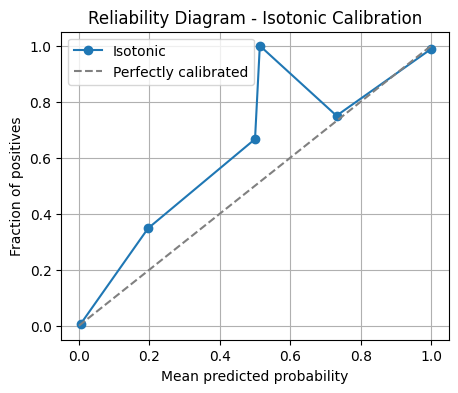

In [57]:
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Brier score and ROC AUC
brier = brier_score_loss(y_test, proba_iso_test)
roc_auc = roc_auc_score(y_test, proba_iso_test)
print("Isotonic calibration - Test set metrics")
print("Brier score:", round(brier,4))
print("ROC AUC:", round(roc_auc,4))

# Reliability diagram
frac_pos, mean_pred = calibration_curve(y_test, proba_iso_test, n_bins=10)

plt.figure(figsize=(5,4))
plt.plot(mean_pred, frac_pos, marker='o', label='Isotonic')
plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram - Isotonic Calibration')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
#Platt scaling is just fitting a sigmoid function to map raw scores to calibrated probabilities.

import numpy as np
from scipy.optimize import minimize

# Calibration data
X_cal = cal_data['score'].values
y_cal = cal_data['target'].values

# Sigmoid function
def sigmoid(s, A, B):
    return 1 / (1 + np.exp(A * s + B))

"""Takes a score s and parameters A, B
Returns a probability between 0 and 1"""

#A_opt and B_opt are your Platt scaling parameters
# Negative log-likelihood
def nll(params, s, y):
    A, B = params
    p = sigmoid(s, A, B)
    # Clip probabilities to avoid log(0)
    p = np.clip(p, 1e-10, 1-1e-10)
    return -np.sum(y*np.log(p) + (1-y)*np.log(1-p))

"""
params = [A, B] → the values we want to optimize
s = raw scores
y = true labels (0 or 1)
p = sigmoid(s, A, B) → predicted probabilities
Clip probabilities to avoid log(0)
"""

# Initial guess for A, B
init_params = [1.0, 0.0]

# Minimize negative log-likelihood
res = minimize(nll, init_params, args=(X_cal, y_cal), method='BFGS')# find A and B that minimize NLL.
A_opt, B_opt = res.x
print("Platt scaling parameters from scratch:")
print("A =", A_opt, "B =", B_opt)


"""Start with initial guess A=1, B=0
Use scipy.optimize.minimize to find A and B that minimize NLL
BFGS = gradient-based optimization method
After optimization: A_opt and B_opt are your Platt scaling parameters"""

# Predict calibrated probabilities
def platt_predict(s):
    return sigmoid(s, A_opt, B_opt)

"""Apply the learned sigmoid to any raw score
Returns calibrated probability"""

# Test set probabilities
X_test_scores = test_data['score'].values
proba_platt_test = platt_predict(X_test_scores)


Platt scaling parameters from scratch:
A = -29.871267551977414 B = 14.166523237730022


Brier score: 0.0099
ROC AUC: 0.9947


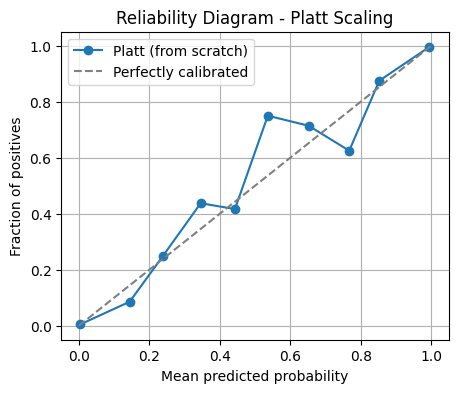

In [61]:
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Metrics
brier = brier_score_loss(test_data['target'].values, proba_platt_test)
roc_auc = roc_auc_score(test_data['target'].values, proba_platt_test)
print("Brier score:", round(brier,4))
print("ROC AUC:", round(roc_auc,4))

# Reliability diagram
frac_pos, mean_pred = calibration_curve(test_data['target'].values, proba_platt_test, n_bins=10)
plt.figure(figsize=(5,4))
plt.plot(mean_pred, frac_pos, marker='o', label='Platt (from scratch)')
plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram - Platt Scaling')
plt.legend()
plt.grid(True)
plt.show()
